In [1]:
# If not installed, run this cell. It is needed for access to GEE
#!pip install ee
#!pip show ee

In [2]:
# If not installed, run this cell. It helps visualization of data
#!pip install geemap
#!pip show geemap

In [3]:
# Import libraries
import ee, datetime, pandas as pd, geemap, ipyleaflet, ipywidgets as widgets, matplotlib.pyplot as plt
import calendar

In [4]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-jvg')

In [5]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [6]:
# HydroSHEDS v1 will be used. Specifically, its HydroBASINS
hydrobasins = ee.FeatureCollection('WWF/HydroSHEDS/v1/Basins/hybas_3')
hybas_id = "HYBAS_ID"
Map.addLayer(hydrobasins, {}, 'HydroBasins')
vector_layer = Map.find_layer("HydroBasins")
vector_layer.interact(opacity=(0, 1, 0.1))

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0),))

In [7]:
output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = ipyleaflet.WidgetControl(widget=output_widget, position="bottomright")
Map.add_control(output_control)

In [8]:
def remove_layer(pre_name):
    layer_names = Map.layers # Get the list of layer names
    layers = Map.layers[:]  # Get the list of layers
    names = [layer.name for layer in layer_names]  # Extract layer names

    for item in names:
        if pre_name in item: # Check if the name is in the item
            index = names.index(item)  # Get the index of the name
            layer = layer_names[index]  # Retrieve the layer at the index
            Map.remove(layer)  # Remove the layer from the map    
            return Map.layers[:]
  
    return layers

# Function to identify the ID of the basin of interest by clicking on the map over the feature of the HydroSHEDS
def handle_interaction(**kwargs):
    latlon = kwargs.get('coordinates')
    if kwargs.get('type') == 'click':
        Map.default_style = {'cursor': 'wait'}
        xy = ee.Geometry.Point(latlon[::-1])
        selected_fc = hydrobasins.filterBounds(xy)

        with output_widget:
            output_widget.clear_output()

            try:
                pre_name = "Identified Basin: "
                Map.layers = remove_layer(pre_name)
                id = selected_fc.first().get(hybas_id).getInfo()
                geom = selected_fc.geometry()
                layer_name = pre_name + str(id)
                Map.addLayer(ee.Image().paint(geom, 0, 2), {'palette': 'red'}, layer_name)
                print(layer_name + "\nLat: " + str(latlon[0]) + " Long: " + str(latlon[1]))
            except Exception as e:
                print('No feature could be found')
                Map.layers = Map.layers[:]

        Map.default_style = {'cursor': 'pointer'}

Map.on_interaction(handle_interaction)

In [36]:
# Function to determine the simulation period and the reporting period
def determine_period(start_date, end_date, warmup_yrs = 0):
    ini_date = str((int(start_date.split("-")[0]) + int(warmup_yrs))) + "-" + start_date.split("-")[1]
    if (end_date.split("-")[1]) == "12":
        fin_date = str(int(end_date.split("-")[0]) + 1) + "-01"
    else:
        fin_date = str(int(end_date.split("-")[0])) + "-" + str(int(end_date.split("-")[1]) + 1)

    if (datetime.datetime(int(ini_date.split("-")[0]), int(ini_date.split("-")[1]), 1) >= datetime.datetime(int(fin_date.split("-")[0]), int(fin_date.split("-")[1]), 1)):
        if (warmup_yrs != 0):
            print ("Start date is finally set beyond or same as the end date! Please consider the implications of the warm-up years. Remember that end date is exclusive")
        else:
            print ("Start date is finally set beyond or same as the end date! Please review your input dates. Remember that end date is exclusive")
        raise SystemExit()

    print ("Simulation period will be from " + ini_date + " to " + end_date)
    return ini_date, fin_date

In [37]:
## Initial parameters ##

# It is recommended using at least 5 years of equilibration period - warm up years. This allows the model to get the water cycling properly.
# When a proper equilibration period is incorporated, "ffcb" value is not going to impact model results
warmup_yrs = 5
start_date = '2008-01'
end_date = '2023-12'
ini_date, fin_date = determine_period(start_date, end_date, warmup_yrs)
selected_basin_id = 6030007000 # This ID must be identified through the interative map above by clicking on the basin of your interest. See the widget on the bottom right side of the map

Simulation period will be from 2013-01 to 2023-12


In [11]:
######################################################
### Starting values for the water balance model - T&M
######################################################

# The recession constant (k) will be determined from hydrographs derived from the gathered streamflow datasets. For the rest of the world, k will be defined as 0.5
k_recession = 0.5 # Temporarily is defined as such

# Initial soil water storage expressed as a fraction of water holding capacity [0-1]
ffcb = 0.1 # 10%

# Base flow of the previous month (mm)
bflow_ant = 10

In [12]:
# HydroSHEDS v1 will be used. Specifically, its HydroBASINS
zoi = hydrobasins.select(hybas_id).filter(ee.Filter.eq(hybas_id, selected_basin_id))
visualization = {
  "color": 'blue',
  "strokeWidth": 1
}
Map.centerObject(zoi.geometry())
Map.addLayer(zoi, visualization, 'Selected Basin')

In [13]:
# Public link to the asset whc: https://code.earthengine.google.com/?asset=projects/ee-jvg/assets/whc_fc33
whc = ee.Image('projects/ee-jvg/assets/whc_fc33')
whc = whc.clip(zoi).divide(1000) # As the raster was originally multiplied by 1000
Map.addLayer(whc, {}, 'Water Holding Capacity')

In [14]:
# TerraClimate layers filtered with "start_date" (inclusive) and "end_date" (exclusive) and clipped to "zoi"
terraclimate = ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE').filter(ee.Filter.date(start_date, fin_date)).map(lambda image: image.clip(zoi))
num_months = terraclimate.size().getInfo()
num_months

192

In [15]:
# Initial images and time to start the water balance
k = ee.Image(k_recession)
st0 = whc.multiply(ffcb)
bf0 = ee.Image(bflow_ant)
time0 = terraclimate.first().get("system:time_start") # Define the initial time (time0) according to the start of the collection

In [16]:
# Initialization of ALL bands.
# Mandatory to cast the type of the data with a .float().

# Initialization of precipitation
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# Initialization of potential evapotranspiration
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

# Initialization of runoff
initial_ro = ee.Image(0).set("system:time_start", time0).select([0], ["ro"]).float()

# Initialization of effective precipitation
initial_ep = ee.Image(0).set("system:time_start", time0).select([0], ["eprec"]).float()

# Initialization of actual evapotranspiration
initial_aet = ee.Image(0).set("system:time_start", time0).select([0], ["aet"]).float()

# Initialization of soil storage, which is considered to be a fraction of WCH
initial_st = st0.set("system:time_start", time0).select([0], ["sstor"]).float()

# Initialization of percolation
initial_pc = ee.Image(0).set("system:time_start", time0).select([0], ["perc"]).float()

# Initialization of base flow, which is considered as defined in Ulmen (2000)
initial_bf = bf0.set("system:time_start", time0).select([0], ["bflow"]).float()

# Initialization of water yield
initial_wy = ee.Image(0).set("system:time_start", time0).select([0], ["wyield"]).float()

In [17]:
# All initial bands are combined into one "ee.Image" by adding them to the first band (wy)
initial_image = initial_wy.addBands(
    ee.Image([initial_pr, initial_pet, initial_ro, initial_ep, initial_aet, initial_st, initial_pc, initial_bf])
)

# Initiatlization of list that will contain new images after each iteration
image_list = ee.List([initial_image])

In [18]:
def water_balance(image, image_list):
    
    # Determine the date of the current ee.Image of the collection.
    localdate = image.get('system:time_start')

    # Import previous image stored in the list
    prev_im = ee.Image(ee.List(image_list).get(-1))

    # Import previous soil storage and baseflow
    # Only those variables of the water balance that work with previous conditions (i.e., i-1)
    prev_st = prev_im.select("sstor")
    prev_bf = prev_im.select("bflow")

    # Import current precipitation, potential evapotranspiration, and runoff
    pr_im = image.select("pr")
    pet_im = image.select("pet").multiply(0.1) # Scale factor: 0.1
    ro_im = image.select('ro')

    # Initialize the new bands associated with wyield, eprec, aet, perc, sstor, and bflow
    new_wy = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["wyield"])
        .float()
    )

    new_ep = (
        pr_im.subtract(ro_im)
        .set("system:time_start", localdate)
        .select([0], ["eprec"])
        .float()
    )

    new_aet = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["aet"])
        .float()
    )

    new_pc = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["perc"])
        .float()
    )

    new_st = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["sstor"])
        .float()
    )

    new_bf = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["bflow"])
        .float()
    )

    # Calculate bands depending on the situation using binary layers with logical operations

    ## CASE 1
    # Define zone1: pixels where EPREC > PET 
    zone1 = new_ep.gt(pet_im)

    # Calculation of AET in zone 1
    zone1_aet = pet_im.rename("aet")
    # Implementation of zone 1 values for AET
    new_aet = new_aet.where(zone1, zone1_aet)

    ## CASE 1.1
    # Define zone11: pixels where (EPREC > PET) and (Si-1 + EPREC - AET > WHC)
    zone11 = zone1.And(prev_st.add(new_ep).subtract(new_aet).gt(whc))

    # Calculation of SSTOR in zone 1.1
    zone11_st = whc.rename("sstor")
    # Implementation of zone 1.1 values for SSTOR
    new_st = new_st.where(zone11, zone11_st)

    # Calculation of PERC in zone 1.1
    zone11_pc = prev_st.add(new_ep).subtract(new_aet).subtract(whc).rename("perc")
    # Implementation of zone 1.1 values for PERC
    new_pc = new_pc.where(zone11, zone11_pc)

    ## CASE 1.2
    # Define zone12: pixels where (EPREC > PET) and (Si-1 + EPREC - AET <= WHC)
    zone12 = zone1.And(prev_st.add(new_ep).subtract(new_aet).lte(whc))

    # Calculation of SSTOR in zone 1.2
    zone12_st = prev_st.add(new_ep).subtract(new_aet).rename("sstor")
    # Implementation of zone 1.2 values for SSTOR
    new_st = new_st.where(zone12, zone12_st)

    ## CASE 2
    # Define zone2: pixels where EPREC <= PET
    zone2 = new_ep.lte(pet_im)

    # Calculation of SSTOR in zone 2
    zone2_st = prev_st.multiply(ee.Image.exp(new_ep.subtract(pet_im).abs().divide(whc).multiply(-1))).rename("sstor")
    # Implementation of zone 2 values for SSTOR
    new_st = new_st.where(zone2, zone2_st)

    # Calculation of AET in zone 2
    zone2_aet = new_ep.add(new_st).subtract(prev_st).rename("aet")
    # Implementation of zone 2 values for AET
    new_aet = new_aet.where(zone2, zone2_aet)

    new_bf_p1 = prev_bf.multiply(k)
    new_bf_p2 = ee.Image(1).subtract(k).multiply(new_pc)
    new_bf = new_bf.add(new_bf_p1).add(new_bf_p2).rename("bflow")

    new_wy = new_wy.add(new_bf).add(ro_im).rename("wyield")

    # Create a mask around area where pixels can effectively be calculated
    # Where we have have PREC as TerraClimate and WHC
    mask = pr_im.gte(0).And(whc.gte(0))
    
    # Apply the mask
    new_wy = new_wy.updateMask(mask)

    # Add all Bands to our ee.Image
    new_image = new_wy.addBands(ee.Image([pr_im, pet_im, ro_im, new_ep, new_aet, new_st, new_pc, new_bf]))
    new_image = new_image.set("system:time_start", localdate) # Needed to have 'start_time' finally assigned correctly
    
    # Add the new ee.Image to the ee.List
    return ee.List(image_list).add(new_image)

In [19]:
#########################
# WATER BALANCE EXECUTION
#########################

# Iterate the user-supplied function to the terraclimate collection
wy_list = terraclimate.iterate(water_balance, image_list)

# Remove the initial image from our list
wy_list = ee.List(wy_list).remove(initial_image)

# Transform the list into an ee.ImageCollection
wy_coll = ee.ImageCollection(wy_list).filter(ee.Filter.date(ini_date, fin_date))

In [20]:
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms").dt.strftime("%Y-%m")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

In [21]:
# Define a location of interest with a point
lon = -63.7788611025714
lat = -6.20924401235051

poi = ee.Geometry.Point(lon, lat)
poi_ft = ee.FeatureCollection(ee.Geometry.Point(lon, lat))
Map.addLayer(poi_ft, {'color': 'red', 'pointSize': 10}, "Point of Interest")

# A nominal scale in meters of the projection to work in [in meters]
scale = 1000

In [45]:
# Let's have a look at the result around a location of interest:
# WARNING: It crashes if the number of simulation years is greater than 11 on a monthly basis, i.e., more than 132 images
arr = wy_coll.getRegion(poi, scale).getInfo()
wb_vars = ["pr", "pet", "ro", "eprec", "aet", "sstor", "perc", "bflow", "wyield"]
rdf = ee_array_to_df(arr, wb_vars).sort_index()
rdf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
2013-01,1356998400000,197,77.8,119,78,77.800000,1.666400e+01,0.200,22.825544,141.825544
2013-02,1359676800000,400,77.4,322,78,77.400000,1.666400e+01,0.600,11.712772,333.712772
2013-03,1362096000000,280,87.1,193,87,86.900299,1.656430e+01,0.000,5.856386,198.856386
2013-04,1364774400000,350,77.5,273,77,76.510374,1.607467e+01,0.000,2.928193,275.928193
2013-05,1367366400000,182,74.4,108,74,73.618740,1.569341e+01,0.000,1.464097,109.464097
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,13,127.7,1,12,11.999103,8.664626e-07,0.000,0.127163,1.127163
2023-09,1693526400000,17,133.7,1,16,15.999999,7.417735e-10,0.000,0.063581,1.063581
2023-10,1696118400000,53,130.3,3,50,50.000000,5.991086e-12,0.000,0.031791,3.031791


In [23]:
#Get values of initial variables for the point of interest
copy_ii = initial_image.set('system:time_start', 0)
intial_imgs = ee.ImageCollection(ee.List([copy_ii]))
initial_arr = intial_imgs.getRegion(poi, scale).getInfo()
idf = ee_array_to_df(initial_arr, wb_vars).sort_index()
idf

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0,0,0,0,1.6664,0,10,0


In [24]:
rdff = pd.concat([idf, rdf])
#rdf.to_excel("D:\Borrar\wb_point.xlsx")
#rdff.to_csv("D:\Borrar\wb_point.csv")
rdff

,time,pr,pet,ro,eprec,aet,sstor,perc,bflow,wyield
datetime,,,,,,,,,,
1970-01,0,0,0.0,0,0,0.000000,1.666400e+00,0.000,10.000000,0.000000
2013-01,1356998400000,197,77.8,119,78,77.800000,1.666400e+01,0.200,22.825544,141.825544
2013-02,1359676800000,400,77.4,322,78,77.400000,1.666400e+01,0.600,11.712772,333.712772
2013-03,1362096000000,280,87.1,193,87,86.900299,1.656430e+01,0.000,5.856386,198.856386
2013-04,1364774400000,350,77.5,273,77,76.510374,1.607467e+01,0.000,2.928193,275.928193
...,...,...,...,...,...,...,...,...,...,...
2023-08,1690848000000,13,127.7,1,12,11.999103,8.664626e-07,0.000,0.127163,1.127163
2023-09,1693526400000,17,133.7,1,16,15.999999,7.417735e-10,0.000,0.063581,1.063581
2023-10,1696118400000,53,130.3,3,50,50.000000,5.991086e-12,0.000,0.031791,3.031791


In [25]:
# Preparing dataframe for chart visualization
new_pd = rdf.drop(["time", "pet", "eprec", "sstor"], axis=1)
new_pd["year"] = new_pd.apply(lambda row: row.name.split("-")[0], axis=1)
new_pd["month"] = new_pd.apply(lambda row: calendar.month_abbr[int(row.name.split("-")[1])], axis=1)
new_pd

,pr,ro,aet,perc,bflow,wyield,year,month
datetime,,,,,,,,
2013-01,197,119,77.800000,0.200,22.825544,141.825544,2013,Jan
2013-02,400,322,77.400000,0.600,11.712772,333.712772,2013,Feb
2013-03,280,193,86.900299,0.000,5.856386,198.856386,2013,Mar
2013-04,350,273,76.510374,0.000,2.928193,275.928193,2013,Apr
2013-05,182,108,73.618740,0.000,1.464097,109.464097,2013,May
...,...,...,...,...,...,...,...,...
2023-08,13,1,11.999103,0.000,0.127163,1.127163,2023,Aug
2023-09,17,1,15.999999,0.000,0.063581,1.063581,2023,Sep
2023-10,53,3,50.000000,0.000,0.031791,3.031791,2023,Oct


In [26]:
# Annual values
pd_yr = new_pd.drop("month", axis=1).groupby(["year"]).sum()
pd_yr

,pr,ro,aet,perc,bflow,wyield
year,,,,,,
2013,2428,1402,920.642584,71.637822,111.700108,1513.700108
2014,2017,984,916.931692,82.136454,69.844384,1053.844384
2015,1853,876,785.336000,158.336000,98.953556,974.953556
2016,2233,1134,973.483960,89.560088,151.399579,1285.399579
2017,2383,1293,955.045325,100.369197,96.371451,1389.371451
2018,2320,1291,911.836442,83.836442,88.873667,1379.873667
2019,2893,1919,849.040989,90.840989,93.653271,2012.653271
2020,2168,1155,837.636001,140.636001,109.538287,1264.538287
2021,2456,1484,794.736001,143.136001,148.540908,1632.540908


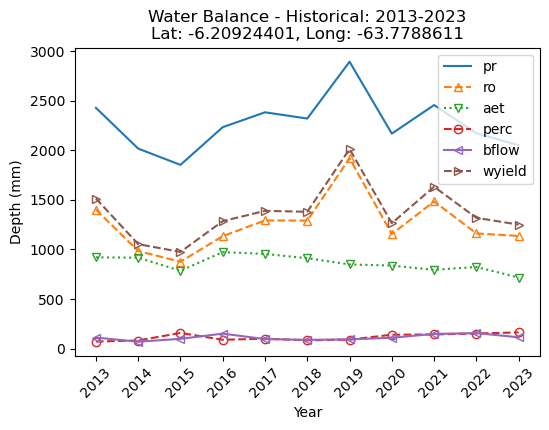

In [27]:
# Plot of yearly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_yr.columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-", "--"]
markers = ["", "^", "v", "o", "<", ">"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_yr[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [28]:
# Monthly values
pd_month = new_pd.drop("year", axis=1).groupby(["month"], sort=False).mean()
pd_month

,pr,ro,aet,perc,bflow,wyield
month,,,,,,
Jan,289.454545,210.272727,78.973756,0.072727,14.476098,224.748826
Feb,296.454545,222.181818,73.944597,0.054545,7.265322,229.447140
Mar,333.181818,250.090909,82.743207,0.000000,3.632661,253.723570
Apr,279.636364,198.636364,80.616587,0.121627,1.877144,200.513508
May,153.636364,67.181818,86.010627,0.065807,0.971475,68.153293
Jun,61.272727,3.000000,44.541735,0.000000,0.485738,3.485738
Jul,30.454545,1.454545,26.921328,0.000000,0.242869,1.697414
Aug,47.090909,2.272727,44.805076,0.000000,0.121434,2.394162
Sep,82.272727,4.181818,69.898404,5.057984,2.589709,6.771527


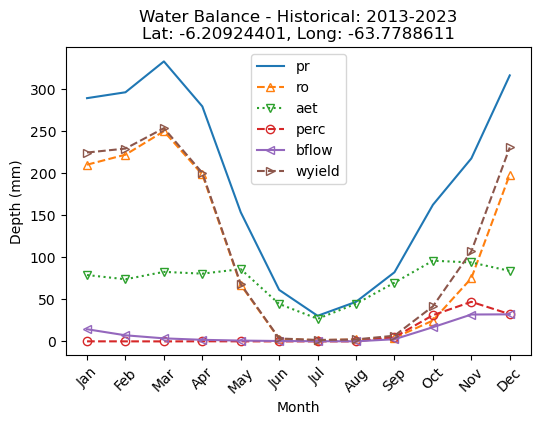

In [29]:
# Plot of monthly water balance
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)

cols = pd_month.columns.tolist()
ls_vars = {}
mk_vars = {}
ls = ["-", "--", ":", "dashed", "-", "--"]
markers = ["", "^", "v", "o", "<", ">"]

for i in range(len(cols)):
    ls_vars[cols[i]] = ls[i]
    mk_vars[cols[i]] = markers[i]

for col in cols:
    ax.plot(pd_month[col], linestyle=ls_vars[col], marker=mk_vars[col], label=col, fillstyle='none')
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel("Depth (mm)")
ax.set_title("Water Balance - Historical: " + pd_yr.index.values.min() + "-" + pd_yr.index.values.max() + "\n"
             + "Lat: " + str(round(lat, 8)) + ", Long: " + str(round(lon, 8)))
ax.tick_params(axis='x', labelrotation=45)

In [34]:
# Let's assign year and month to each image
wy_coll = wy_coll.map(lambda image: image.set("year", ee.Image(image).date().get("year")))
wy_coll = wy_coll.map(lambda image: image.set("month", ee.Image(image).date().get("month")))

In [69]:
# Define a list of unique observation years from the image collection
years = ee.List(wy_coll.aggregate_array('year')).distinct().sort()

In [122]:
# Function to map over the list of water balance variables to build a list of image composites
def create_annual_composite(wb_var, years):
    
    composite = wy_coll.select(wb_var)
    
    new_img = ee.Image(0).select([0], ["delete"]).float()
    bands = ee.List([years]).map(lambda yr: composite.filterMetadata('year', 'equals', yr).reduce(ee.Reducer.sum()).set('year', yr))

    # Add all Bands to our ee.Image
    new_image = new_img.addBands(ee.Image(bands)).rename(wb_var)

    # Create a mask around area where pixels can effectively be calculated
    # Where we have have WHC
    mask = whc.gte(0)

    # Apply the mask
    new_image = new_image.updateMask(mask)

    # Add the new ee.Image to the ee.List
    return ee.List(annual_lst).add(new_image.select(new_image.bandNames().slice(1)))

annual_lst = ee.List([])
# Map over the list of water balance variables to generate the list of composites
annual_ic = ee.ImageCollection(ee.List([wb_vars]).map(create_annual_composite, years))

In [ ]:
# Define arguments for the getFilmstripThumbURL function parameters.
filmArgs = {
  "dimensions": 128,
  "region": zoi,
  "crs": 'EPSG:3857',
  "min": -40.0,
  "max": 35.0,
  "palette": ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']
}

# Print a URL that will produce the filmstrip when accessed.
print(annual_ic.getFilmstripThumbURL(filmArgs))

In [30]:
#############################
# HELPFUL CODES
#############################

# To know how many bands an ImageCollection has
#terraclimate.size().getInfo()

# To get the attributes (columns) as pandas dataframe
#geemap.ee_to_df(hydrobasins)

# Display imaga metada
#display(ee.ImageCollection.first())

In [31]:
# Access an image asset from my account to test the code
#guate_bdry = ee.FeatureCollection('users/jvg/guatemala_buffer')
#guate_geom = guate_bdry.geometry()
#Map.centerObject(guate_geom)
#Map.addLayer(guate_bdry, {"color": 'red'}, 'Guatemala Boundary')